# Character-level Convolutional Network
In this notebook we train and evaluate the performance of a convolutional neural network in the task of detecting misinformation in WhatsApp texts.

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from utils import getTestMetrics
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline
sns.set(style="whitegrid")

Using TensorFlow backend.


## Results

In [2]:
#save results in
base = '2018'
subset = 'viral'
experiment = 'cnn-zhang'
path_dir = 'results/' + str(base) + '/' + subset + '/dl/'
file = 'dl_results.csv'
filepath = path_dir + file
filepath

'results/2018/viral/dl/dl_results.csv'

In [3]:
df_results = pd.read_csv(filepath)
#cols = df_results.columns.tolist()
#cols = cols[-1:] + cols[:-1]
#df_results = df_results[cols]
#df_results = df_results.reset_index()
#df_results = df_results.drop(columns = ['index'])
df_results = df_results.sort_values(by='f1 score',ascending=False)
df_results.style.background_gradient(cmap='Blues')

,experiment,vocab,layers,max_features,batch_size,embedding_dims,filters,kernel_size,hidden_dims,epochs,accuracy,precision,recall,f1 score,auc score
0,cnn1,705,"<keras.layers.embeddings.Embedding, <keras.layers.core.Dropout, <keras.layers.convolutional.Conv1D, <keras.layers.pooling.GlobalMaxPooling1D, <keras.layers.core.Dense, <keras.layers.core.Dropout, <keras.layers.core.Activation, <keras.layers.core.Dense, <keras.layers.core.Activation,",2000,32,100,250,15,250,5,0.776727,0.770667,0.658314,0.710074,0.850674
1,cnn1-lowercase,665,"<keras.layers.embeddings.Embedding, <keras.layers.core.Dropout, <keras.layers.convolutional.Conv1D, <keras.layers.pooling.GlobalMaxPooling1D, <keras.layers.core.Dense, <keras.layers.core.Dropout, <keras.layers.core.Activation, <keras.layers.core.Dense, <keras.layers.core.Activation,",2000,32,100,250,15,250,8,0.761589,0.722090,0.692483,0.706977,0.831640


In [4]:
filepath_df = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
df = pd.read_csv(filepath_df)

if subset == 'viral':
    df = df[df['viral']==1]
    
df.head(5)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,sharings,text,misinformation
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0
15,3631133147603888180,10/08/18,14:31,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,99,18,1,2,"No dia 07 de Outubro, quando for votar, não es...",1
26,-4391661641377612003,11/08/18,19:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,114,17,1,6,Devido a aborrecimentos nas varias redes socia...,0
43,3631133147603888180,15/08/18,19:23,55,BRASIL,BRA,17,São Paulo,2018_1,0,1,330,47,1,7,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0
103,-4391661641377612003,22/08/18,22:11,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,226,39,1,8,Como são as coisas.\nChefe do jacaré aparece n...,1


In [7]:
#removing duplicates
df = df.drop_duplicates(subset=['text'])
#texts
texts = df[df['midia']==0]['text']
texts = [t.lower() for t in texts]
#target
y = df[df['midia']==0]['misinformation']

### Train-test split

In [9]:
train_texts, test_texts, y_train, y_test = train_test_split(texts, y, test_size=0.2, stratify = y, random_state=42)

# Char vocabulary, encoding and decoding

In [10]:
# =======================Convert string to index================
# Tokenizer
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(train_texts)
# If we already have a character list, then replace the tk.word_index
# If not, just skip below part

In [12]:
txt_list = list(texts)
if 'lowercase' in experiment:
    txt_list = [t.lower() for t in txt_list]
    
txt_str = " ".join(txt_list)
#word_list = msg_str.split()
char_list = list(txt_str)
alphabet = set(char_list)
features = len(alphabet)
print(features)
for v in list(alphabet):
    print(v, end = ' ')

665
ó 🇧 � 🎸 🦇 ↖ ❣ é 🎾 🚈 👩 ⢻ ▪ ä 🌍 🤦 🚶 🎖 © 💫 9 🏆 😀 💭 ✅ í 🇵 😧 🧚 🚨 à ☹ 😇 🤪 ] 😶 🌺 💀 _ o 💶 ❤ 🏃 7 📜 🍦 🙋 ⠈ 🇿 🌐 👍 😪 🌪 🏽 x 📩 🇷 ⡄ 📗 ☢ ❓ 💏 🤤 🤥 ⣉ ō . v ù 🐠 🇫 🏍 👜 📈 🔑 🇭 🔥 🛴 😨 🚛 🐴 😓 🤡 ■ 💔 ☕ 🗳 ⚠ 🤷 👭 😲 🤐 \ 🤝 😐 👁 🔛 💛 🔍 	 🛑 ⣠ ć e 🙇 🦑 🗣 ┣ ♦ 🕵 ° 🌎 w 🚓 ﻿ 🛇 🇺 🛸 🎺 ⠛ 💸 ⠂ 😋 📷 ü ⣼ 😳 💵 ” ⚜ 🅱 👴 ⡟ ⠟ 🔉 ❗ ɨ 🏹 📄  🍞 ⛓ 🌝 ➡ ┃ 🚎 ⣆ ѕ 🏾 ✴ 🇮 < 📉 🍮 📆 😻 🕓 👶 ▶ - 💴 ɴ 🇹 
 💋 🔈 ️ á 🥇 ◡ 🎵 😸 ❎ , ; 🔵 😃 ö 🗡 🐟 👸 🐎 🔗 🔴 🔰 🚙 🌽 📬 ⠄ 👰 🍛 😮 / 📖 z 🤜 🎥 》 🙉 👱 а ⣙ 👂 : 👢 ⢾ 📍 🎷 d ⤵ 🤚  😰 a 🍨 🚌 🔎 ➖ 🇼 💣 ⚖ g ( 🚗 👿 🔪 🇻 🤠 🌞 🏠 😟 🌻 👪 ♨ * 😴 ́ ⣿ 🍔 🤵 φ 🍃 ⚡ è ã 🎓 ♂ 👈 🍤 ⃣ ⣽ 🧑 👹 ⣄ 🌟 🔬 [ 0 🎗 ┗ k 🤬 😡 😩 👀 ⠿ 🍢 ̄ 🏼 ↘ 🍼 ━ 😏 💪 ⣤ 🌹 🔸 🤙 🔊 👇 💎 😉 💼 ✳ ┳ 😁 🤭 5 💨 — 🌃  😺 🆙 t ⠒ ! 🎹 ⚽ m 🏻 🏡 🔨 📣 ⡏ 🌷 📝 🧔 🇨 🎤 🇦 🚔 🧒 🛒 🚝 💃 💐 🏫 👬 🙆 😑 ⡻ ⢀ 🕔 👕 ⢠ 🇱 🏷 ♻ » ☠ 🖍 ⡛ 👽 ‘ 🙈 ⡇ 🥩 😈 📘 🍺 📕 # " 🚩 🗞 🚍 🇳 p 🚕 🚫 y   💓 😫 🙌 ✔ @ ) р 🤳 🐁 👋 💘 i 🌱 💂 « 😄  🥀 ♀ 🌵 🥁 🤟 🎙 📐 🏁 💦 🎧 🛡 🤮 ⠢ 🏘 💯  💙 ‒ 🎶 🇯 > ⠋ 💊 🕯 💩 ⠉ ▫ 👦 🍣 › 🐀 🐍 õ 😯 🚦 🖋 ⣴ r 2 📻 💰 📛 s ❌ ⣈ ⏬ ú 😎 ⡀ ⠍ 💝 🔫 🖕 ⢸ 🧐 

In [13]:
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1

In [14]:
# Use char_dict to replace the tk.word_index
tk.word_index = char_dict.copy()
# Add 'UNK' to the vocabulary
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

# Convert string to index
train_sequences = tk.texts_to_sequences(train_texts)
test_texts = tk.texts_to_sequences(test_texts)

# Padding
train_data = pad_sequences(train_sequences, maxlen=1014, padding='post')
test_data = pad_sequences(test_texts, maxlen=1014, padding='post')

# Convert to numpy array
train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

In [39]:
train_data.shape

(4227, 1014)

In [58]:
# =======================Get classes================
train_classes = y_train.values
train_class_list = [x - 1 for x in train_classes]
train_classes = train_classes.reshape(train_classes.shape[0],1)

test_classes = y_test.values
test_class_list = [x - 1 for x in test_classes]
test_classes = test_classes.reshape(test_classes.shape[0],1)

In [66]:
# =====================Char CNN=======================
# parameter
input_size = 1014
vocab_size = len(tk.word_index)
embedding_size = 666
conv_layers = [[256, 7, 3],
               [256, 7, 3],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, 3]]


In [67]:
fully_connected_layers = [1024, 1024]
num_of_classes = 2
dropout_p = 0.5
optimizer = 'adam'
loss = 'binary_crossentropy'

In [68]:
# Embedding weights
embedding_weights = []  # (70, 69)
embedding_weights.append(np.zeros(vocab_size))  # (0, 69)

for char, i in tk.word_index.items():  # from index 1 to 69
    onehot = np.zeros(vocab_size)
    onehot[i - 1] = 1
    embedding_weights.append(onehot)

embedding_weights = np.array(embedding_weights)
print('Load')

# Embedding layer Initialization
embedding_layer = Embedding(vocab_size + 1,
                            embedding_size,
                            input_length=input_size,
                            weights=[embedding_weights])

Load


In [69]:
embedding_layer.weights

[]

In [74]:
# Model Construction
# Input
inputs = Input(shape=(input_size,), name='input', dtype='int64')  # shape=(?, 1014)
# Embedding
x = embedding_layer(inputs)
# Conv
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x)
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)  # Final shape=(None, 34, 256)
x = Flatten()(x)  # (None, 8704)

In [75]:
# Fully connected layers
for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x)  # dense_size == 1024
    x = Dropout(dropout_p)(x)
# Output Layer
predictions = Dense(1, activation='sigmoid')(x)
# Build model
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])  # Adam, binary_crossentropy
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1014)              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 1014, 666)         444222    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1008, 256)         1193728   
_________________________________________________________________
activation_7 (Activation)    (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 336, 256)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 330, 256)          459008    
_________________________________________________________________
activation_8 (Activation)    (None, 330, 256)          0         
__________

In [76]:
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)

x_train = train_data[indices]
y_train = train_classes[indices]

x_test = test_data
y_test = test_classes

In [78]:
history = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=128,
          epochs=8,
          validation_split=0.1,
          verbose=1)

Train on 4227 samples, validate on 1057 samples
Epoch 1/8
4227/4227 [==============================] - 378s 89ms/step - loss: 0.6501 - acc: 0.6279 - val_loss: 0.6519 - val_acc: 0.6178
Epoch 2/8
4227/4227 [==============================] - 377s 89ms/step - loss: 0.6309 - acc: 0.6369 - val_loss: 0.6162 - val_acc: 0.6613
Epoch 3/8
4227/4227 [==============================] - 377s 89ms/step - loss: 0.6091 - acc: 0.6591 - val_loss: 0.7315 - val_acc: 0.5904
Epoch 4/8
4227/4227 [==============================] - 379s 90ms/step - loss: 0.6110 - acc: 0.6631 - val_loss: 0.6004 - val_acc: 0.6651
Epoch 5/8
4227/4227 [==============================] - 375s 89ms/step - loss: 0.5692 - acc: 0.6925 - val_loss: 0.6427 - val_acc: 0.6197
Epoch 6/8
4227/4227 [==============================] - 374s 89ms/step - loss: 0.5294 - acc: 0.7216 - val_loss: 0.9060 - val_acc: 0.5970
Epoch 7/8
4227/4227 [==============================] - 375s 89ms/step - loss: 0.5828 - acc: 0.7111 - val_loss: 0.6389 - val_acc: 0.6566


In [42]:
#history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

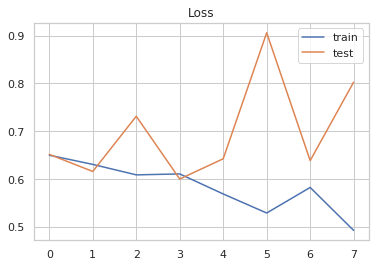

In [79]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

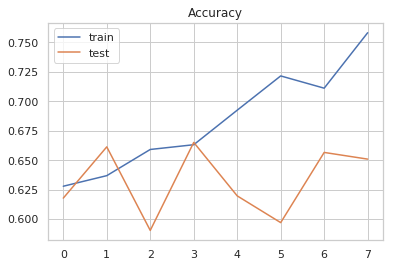

In [80]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [83]:
y_prob = model.predict(x_test)
y_pred = [0 if x < 0.5 else 1 for x in y_prob]

In [82]:
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

NameError: name 'y_pred' is not defined

In [64]:
layers = ''
for layer in model.layers:
    layers += str(layer) + '/'
    
list_layers = layers.split('/')
list_layers = list_layers[:-1]
list_layers

layers = ''
for layer in list_layers:
    splitted = layer.split(' object at ')
    layers += splitted[0] + ', '
layers

'<keras.layers.embeddings.Embedding, <keras.layers.core.Dropout, <keras.layers.convolutional.Conv1D, <keras.layers.pooling.GlobalMaxPooling1D, <keras.layers.core.Dense, <keras.layers.core.Dropout, <keras.layers.core.Activation, <keras.layers.core.Dense, <keras.layers.core.Activation, '

In [66]:
df_metrics = pd.DataFrame({'experiment':[experiment],
                                 'vocab':[features],
                                 'layers':[layers],
                                 'max_features':[max_features],
                                 'batch_size':[batch_size],
                                 'embedding_dims':[embedding_dims],
                                 'filters':[filters],
                                 'kernel_size':[kernel_size], 
                                 'hidden_dims':[hidden_dims], 
                                 'epochs':[epochs],
                                 'accuracy':[acc],
                                 'precision': [precision],
                                 'recall': [recall],
                                 'f1 score': [f1],
                                 'auc score': [roc_auc]})
df_metrics

,experiment,vocab,layers,max_features,batch_size,embedding_dims,filters,kernel_size,hidden_dims,epochs,accuracy,precision,recall,f1 score,auc score
0,cnn1-lowercase,665,"<keras.layers.embeddings.Embedding, <keras.lay...",2000,32,100,250,15,250,8,0.761589,0.72209,0.692483,0.706977,0.83164


In [68]:
df_results = pd.read_csv(filepath)
df_results = pd.concat([df_results, df_metrics])
df_results.drop_duplicates(inplace=True)
df_results.to_csv(filepath, index = False)
df_results

,experiment,vocab,layers,max_features,batch_size,embedding_dims,filters,kernel_size,hidden_dims,epochs,accuracy,precision,recall,f1 score,auc score
0,cnn1,705,"<keras.layers.embeddings.Embedding, <keras.lay...",2000,32,100,250,15,250,5,0.776727,0.770667,0.658314,0.710074,0.850674
1,cnn1-lowercase,665,"<keras.layers.embeddings.Embedding, <keras.lay...",2000,32,100,250,15,250,8,0.761589,0.722090,0.692483,0.706977,0.831640


# Errors examples

In [58]:
full_texts_train, full_texts_test, yf_train, yf_test = train_test_split(texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

In [59]:
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
y_fails = y_test - y_pred
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

print('Total test data:', len(y_pred))
print('False negative: ',len(FN))
print('False positive: ',len(FP))

Total test data: 1057
False negative:  150
False positive:  86


In [60]:
full_texts_test = list(full_texts_test)
texts_FN = [full_texts_test[fn] for fn in FN]
texts_FP = [full_texts_test[fp] for fp in FP]

## False negative

In [61]:
for fn in texts_FN:
    print()
    print('***')
    print(fn)
    print('***')
    print()


***
Gente Apenas Minha Opinião então Vamos lá

No Dia 06 de Junho TSE Derruba o Voto Impresso de Autoria do deputado Federal Candidato a presidente Jair Bolsonaro

No Dia 06 de Setembro Jair Bolsonaro Sofre um Atentado que Seria pra MATAR

Um Dia Antes da Eleição Dia 06; Coincidência Se Juntar as Datas dar Certos 666 
Agora Bolsonaro corre novo Risco...

A que Interessa Isso ? Nova Ordem Mundial / Marconaria ? / iluminati ? / 
Peço que Compartilhem 
E Faca Chegar ao Bolsonaro

Breno Washington MG
Juntos somos fortes
***


***
Testemunho altamente confiável do meu amigo Dante Mantovani! Muito obrigado pelo texto tão esclarecedor e desmistificador, meu amigo: 

Após ter acompanhado Jair Bolsonaro pelo interior de SP por quatro cidades (Presidente Prudente, Araçatuba, Glicério e São José do Rio Preto), divido com vocês o que percebi até aqui:

1-)ao contrário do estereótipo que a mídia criou e que impõe goela abaixo ao seu público, a personalidade de Jair Bolsonaro é tremendamente afável

## False positive

In [62]:
for fp in texts_FP:
    print()
    print('***')
    print(fp)
    print('***')
    print()


***
TEXTO DA FUNDADORA DO DIRETÓRIO DO PT EM ARACAJU

Esquerda brasileira, chega de apontar culpados! Está na hora de assumir o ocorrido e partir prum mea culpa já!, antes que os Dórias e Bolssonaros assumam o poder! Quem elegeu Temer não foram os coxinhas. Parem de tergiversar. Temer foi eleito por vocês com dinheiro público desviado de hospitais, creches e escolas! O resto é retórica, ou ilação como vocês agora costumam chamar o que nós brasileiros conhecemos como mentira!

A arrogância da esquerda de acreditar que lida com tolos e que porta o Santo Graal está no pano de fundo de sua derrocada mundo afora.

Vamos fazer diferente e lavar a jato essa roupa suja antes que seja tarde! A máscara caiu!

Um homem que responsabiliza a companheira morta para não assumir seus atos é um covarde e não herói . Essa inversão de valores para mim é assustadora...

E não me venham falar da corrupção que existe desde a época de CABRAL que não somos trouxinhas...Nós militamos no PT e construímos esse 

# Separated embedding layer

In [63]:
# specifying the input shape
no_docs = len(X_train)
input=Input(shape=(no_docs,maxlen),dtype='float64')

'''
shape of input. 
each document has 12 element or words which is the value of our maxlen variable.
'''

word_input=Input(shape=(maxlen,),dtype='float64')  

# creating the embedding
word_embedding=Embedding(input_dim = max_features, output_dim = embedding_dims, input_length=maxlen)(word_input)

word_vec=Flatten()(word_embedding) # flatten
embed_model =Model([word_input],word_vec) # combining all into a Keras model

NameError: name 'Input' is not defined